In [1]:
!pip install -q tensorflow matplotlib scikit-learn

import os
import gc
import pathlib
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from collections import Counter

print(" TensorFlow version:", tf.__version__)
print(" GPU available:", len(tf.config.list_physical_devices('GPU')) > 0)

 TensorFlow version: 2.19.0
 GPU available: True


In [2]:
from google.colab import drive
drive.mount('/content/drive')

DATA_DIR = "/content/drive/MyDrive/palm-disease-dataset"
print(f"\n Dataset directory: {DATA_DIR}")
!ls -la "$DATA_DIR"

Mounted at /content/drive

 Dataset directory: /content/drive/MyDrive/palm-disease-dataset
total 16
drwx------ 2 root root 4096 Oct 26 18:29  Dryness
drwx------ 2 root root 4096 Oct 26 18:29 'Fungal disease'
drwx------ 2 root root 4096 Oct 26 18:29 'Magnesium Deficiency'
drwx------ 2 root root 4096 Oct 26 18:29 'Scale insect'


In [3]:
data_root = pathlib.Path(DATA_DIR)
classes = sorted([p.name for p in data_root.iterdir() if p.is_dir()])
print("Classes found:", classes)

all_files = []
all_labels = []

for i, cls in enumerate(classes):
    p = data_root / cls
    jpg_files = (list(p.glob("*.jpg")) + list(p.glob("*.JPG")) +
                 list(p.glob("*.jpeg")) + list(p.glob("*.JPEG")))
    jpg_files = [str(f) for f in jpg_files]

    all_files += jpg_files
    all_labels += [i] * len(jpg_files)
    print(f"  {cls}: {len(jpg_files)} images")

print(f"\n Total JPG images: {len(all_files)}")

Classes found: ['Dryness', 'Fungal disease', 'Magnesium Deficiency', 'Scale insect']
  Dryness: 23 images
  Fungal disease: 8 images
  Magnesium Deficiency: 12 images
  Scale insect: 84 images

 Total JPG images: 127


In [4]:
print("\n" + "="*60)
print("VALIDATING ALL FILES")
print("="*60)

IMG_SIZE = 384

def test_file(file_path):
    """Test if a file can be decoded properly."""
    try:
        if not os.path.exists(file_path):
            return False, "Not found"

        file_size = os.path.getsize(file_path)
        if file_size < 5000:
            return False, f"Too small ({file_size}B)"

        img = tf.io.read_file(file_path)
        img = tf.io.decode_jpeg(img, channels=3)
        img = tf.image.convert_image_dtype(img, tf.float32)
        img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])

        if img.shape != (IMG_SIZE, IMG_SIZE, 3):
            return False, f"Bad shape {img.shape}"

        return True, "OK"
    except Exception as e:
        return False, str(e)[:50]

valid_files = []
valid_labels = []
corrupted_count = 0

for idx, (file_path, label) in enumerate(zip(all_files, all_labels)):
    ok, msg = test_file(file_path)
    if ok:
        valid_files.append(file_path)
        valid_labels.append(label)
    else:
        print(f"  Skipping: {os.path.basename(file_path)} - {msg}")
        corrupted_count += 1

    if (idx + 1) % 20 == 0:
        print(f"  ✓ Validated {idx+1}/{len(all_files)}")

print(f"\nValid files: {len(valid_files)}/{len(all_files)}")
print(f"Corrupted/skipped: {corrupted_count}")

all_files = valid_files
all_labels = valid_labels

print("\nClass distribution:")
for i, cls in enumerate(classes):
    count = all_labels.count(i)
    print(f"  {cls}: {count} images")


VALIDATING ALL FILES
  ✓ Validated 20/127
  ✓ Validated 40/127
  ✓ Validated 60/127
  ✓ Validated 80/127
  ✓ Validated 100/127
  ✓ Validated 120/127

Valid files: 127/127
Corrupted/skipped: 0

Class distribution:
  Dryness: 23 images
  Fungal disease: 8 images
  Magnesium Deficiency: 12 images
  Scale insect: 84 images


In [5]:
train_files, test_files, train_labels, test_labels = train_test_split(
    all_files, all_labels, test_size=0.15, stratify=all_labels, random_state=42
)
train_files, val_files, train_labels, val_labels = train_test_split(
    train_files, train_labels, test_size=0.15, stratify=train_labels, random_state=42
)

print("✅ Dataset split:")
print(f"  Train: {len(train_files)} images")
print(f"  Val:   {len(val_files)} images")
print(f"  Test:  {len(test_files)} images")

print("\nTrain distribution:", Counter(train_labels))
print("Val distribution:", Counter(val_labels))
print("Test distribution:", Counter(test_labels))

✅ Dataset split:
  Train: 90 images
  Val:   17 images
  Test:  20 images

Train distribution: Counter({3: 60, 0: 16, 2: 8, 1: 6})
Val distribution: Counter({3: 11, 0: 3, 2: 2, 1: 1})
Test distribution: Counter({3: 13, 0: 4, 2: 2, 1: 1})


In [6]:
counter = Counter(train_labels)
total = sum(counter.values())
class_weights = {i: total / (len(counter) * cnt) for i, cnt in counter.items()}

print("Class weights for imbalance:")
for i, cls in enumerate(classes):
    print(f"  {cls}: {class_weights[i]:.3f}")

Class weights for imbalance:
  Dryness: 1.406
  Fungal disease: 3.750
  Magnesium Deficiency: 2.812
  Scale insect: 0.375


In [7]:
BATCH_SIZE = 8
AUTOTUNE = tf.data.AUTOTUNE

print("Loading all data into memory for stable training...")

def load_and_preprocess(file_paths, labels):
    """Load all images into numpy arrays."""
    images = []
    for file_path in file_paths:
        img = tf.io.read_file(file_path)
        img = tf.io.decode_jpeg(img, channels=3)
        img = tf.image.convert_image_dtype(img, tf.float32)
        img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
        images.append(img.numpy())
    return np.array(images), np.array(labels)

# Load training data
print("  Loading training data...")
X_train, y_train = load_and_preprocess(train_files, train_labels)
y_train_oh = tf.keras.utils.to_categorical(y_train, len(classes))

# Load validation data
print("  Loading validation data...")
X_val, y_val = load_and_preprocess(val_files, val_labels)
y_val_oh = tf.keras.utils.to_categorical(y_val, len(classes))

# Load test data
print("  Loading test data...")
X_test, y_test = load_and_preprocess(test_files, test_labels)
y_test_oh = tf.keras.utils.to_categorical(y_test, len(classes))

print(f"\n Data loaded:")
print(f"  X_train: {X_train.shape}, y_train: {y_train_oh.shape}")
print(f"  X_val: {X_val.shape}, y_val: {y_val_oh.shape}")
print(f"  X_test: {X_test.shape}, y_test: {y_test_oh.shape}")

Loading all data into memory for stable training...
  Loading training data...
  Loading validation data...
  Loading test data...

 Data loaded:
  X_train: (90, 384, 384, 3), y_train: (90, 4)
  X_val: (17, 384, 384, 3), y_val: (17, 4)
  X_test: (20, 384, 384, 3), y_test: (20, 4)


In [8]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.2),
], name="data_augmentation")

print(" Data augmentation layers created")

 Data augmentation layers created


In [9]:
def build_model(num_classes=len(classes), img_size=IMG_SIZE):
    """Build transfer learning model."""

    # Load pretrained base
    base = tf.keras.applications.EfficientNetV2B0(
        include_top=False,
        input_shape=(img_size, img_size, 3),
        weights="imagenet"
    )
    base.trainable = False  # Freeze initially

    # Build model
    inputs = layers.Input(shape=(img_size, img_size, 3))

    # Data augmentation (only active during training)
    x = data_augmentation(inputs)

    # Preprocessing
    x = tf.keras.applications.efficientnet_v2.preprocess_input(x)

    # Base model
    x = base(x, training=False)

    # Classification head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = tf.keras.Model(inputs, outputs)
    return model, base

model, base_model = build_model()
model.summary()


24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 384, 384, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 384, 384, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 12, 12, 1280)   │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,248,276 (23.84 MB)

 Trainable params: 328,964 (1.25 MB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [10]:
NUM_CLASSES = len(classes)
LABEL_SMOOTH = 0.05

loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTH)
optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-5)

model.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=['accuracy']
)

print(" Model compiled")

 Model compiled


In [11]:
from tensorflow.keras.callbacks import (
    ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger
)

ckpt_path = "palm_model_best.keras"
checkpoint = ModelCheckpoint(
    ckpt_path, monitor='val_accuracy', verbose=1,
    save_best_only=True, mode='max'
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.5, patience=3,
    min_lr=1e-7, mode='max', verbose=1
)
early = EarlyStopping(
    monitor='val_accuracy', patience=10,
    restore_best_weights=True, mode='max', verbose=1
)
csvlog = CSVLogger("palm_training_log.csv")

callbacks = [checkpoint, reduce_lr, early, csvlog]
print("Callbacks configured")

Callbacks configured


In [12]:
print("\n" + "="*60)
print("PHASE 1: TRAINING HEAD (BASE FROZEN)")
print("="*60)

EPOCHS_PHASE1 = 15

history_phase1 = model.fit(
    X_train, y_train_oh,
    validation_data=(X_val, y_val_oh),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS_PHASE1,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

print("\n Phase 1 complete!")


PHASE 1: TRAINING HEAD (BASE FROZEN)
Epoch 1/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.2109 - loss: 1.7325
Epoch 1: val_accuracy improved from -inf to 0.11765, saving model to palm_model_best.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 25s 656ms/step - accuracy: 0.2092 - loss: 1.7087 - val_accuracy: 0.1176 - val_loss: 1.3144 - learning_rate: 0.0010
Epoch 2/15
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.4295 - loss: 1.7565
Epoch 2: val_accuracy improved from 0.11765 to 0.17647, saving model to palm_model_best.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.4250 - loss: 1.7334 - val_accuracy: 0.1765 - val_loss: 1.4265 - learning_rate: 0.0010
Epoch 3/15
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.1204 - loss: 1.6982
Epoch 3: val_accuracy did not improve from 0.17647
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.1173 - loss: 1.6742 - val_accuracy: 0.1176 - val_loss: 1.3884 - learning_rate: 0.0010
Epoch 4/15
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/s

In [13]:
print("\n" + "="*60)
print("PHASE 2: FINE-TUNING TOP LAYERS")
print("="*60)

# Unfreeze top layers of base model
base_model.trainable = True
for layer in base_model.layers[:-30]:  # Freeze all except last 30
    layer.trainable = False

print(f"Trainable layers: {sum([1 for l in base_model.layers if l.trainable])}")

# Recompile with lower learning rate
optimizer_fine = tf.keras.optimizers.AdamW(learning_rate=1e-5, weight_decay=1e-6)
model.compile(
    optimizer=optimizer_fine,
    loss=loss_fn,
    metrics=['accuracy']
)

EPOCHS_PHASE2 = 20

history_phase2 = model.fit(
    X_train, y_train_oh,
    validation_data=(X_val, y_val_oh),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS_PHASE2,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

print("\n Phase 2 complete!")


PHASE 2: FINE-TUNING TOP LAYERS
Trainable layers: 30
Epoch 1/20
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5490 - loss: 1.7176
Epoch 1: val_accuracy did not improve from 0.70588
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 434ms/step - accuracy: 0.5534 - loss: 1.6823 - val_accuracy: 0.6471 - val_loss: 1.2899 - learning_rate: 1.0000e-05
Epoch 2/20
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.5447 - loss: 1.5284
Epoch 2: val_accuracy did not improve from 0.70588
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.5429 - loss: 1.5320 - val_accuracy: 0.6471 - val_loss: 1.2860 - learning_rate: 1.0000e-05
Epoch 3/20
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.5840 - loss: 1.5569
Epoch 3: val_accuracy did not improve from 0.70588
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.5728 - loss: 1.5405 - val_accuracy: 0.6471 - val_loss: 1.3069 - learning_rate: 1.0000e-05
Epoch 4/20
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.2765 - loss: 1.6732
Epoch 4: val_accura

In [14]:
print("\n" + "="*60)
print("TEST SET EVALUATION")
print("="*60)

# Load best model
model.load_weights(ckpt_path)

# Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test_oh, verbose=0)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Predictions
y_pred_probs = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification report
print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_test, y_pred, target_names=classes, digits=3))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)



TEST SET EVALUATION


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 62 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



Test Accuracy: 0.6500
Test Loss: 1.3519

CLASSIFICATION REPORT
                      precision    recall  f1-score   support

             Dryness      0.000     0.000     0.000         4
      Fungal disease      0.000     0.000     0.000         1
Magnesium Deficiency      0.000     0.000     0.000         2
        Scale insect      0.684     1.000     0.812        13

            accuracy                          0.650        20
           macro avg      0.171     0.250     0.203        20
        weighted avg      0.445     0.650     0.528        20


Confusion Matrix:
[[ 0  0  1  3]
 [ 0  0  0  1]
 [ 0  0  0  2]
 [ 0  0  0 13]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


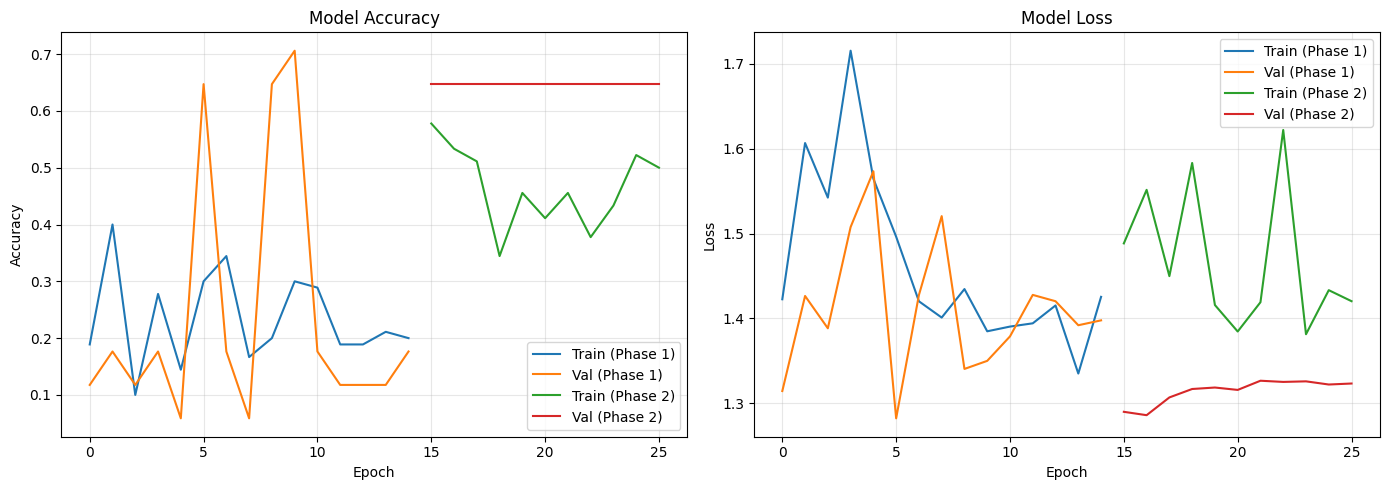

 Plot saved to drive


In [15]:
def plot_history(history1, history2=None):
    """Plot training history."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Accuracy
    axes[0].plot(history1.history['accuracy'], label='Train (Phase 1)')
    axes[0].plot(history1.history['val_accuracy'], label='Val (Phase 1)')
    if history2:
        offset = len(history1.history['accuracy'])
        epochs2 = range(offset, offset + len(history2.history['accuracy']))
        axes[0].plot(epochs2, history2.history['accuracy'], label='Train (Phase 2)')
        axes[0].plot(epochs2, history2.history['val_accuracy'], label='Val (Phase 2)')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_title('Model Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Loss
    axes[1].plot(history1.history['loss'], label='Train (Phase 1)')
    axes[1].plot(history1.history['val_loss'], label='Val (Phase 1)')
    if history2:
        axes[1].plot(epochs2, history2.history['loss'], label='Train (Phase 2)')
        axes[1].plot(epochs2, history2.history['val_loss'], label='Val (Phase 2)')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].set_title('Model Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/training_history.png', dpi=150, bbox_inches='tight')
    plt.show()

plot_history(history_phase1, history_phase2)
print(" Plot saved to drive")

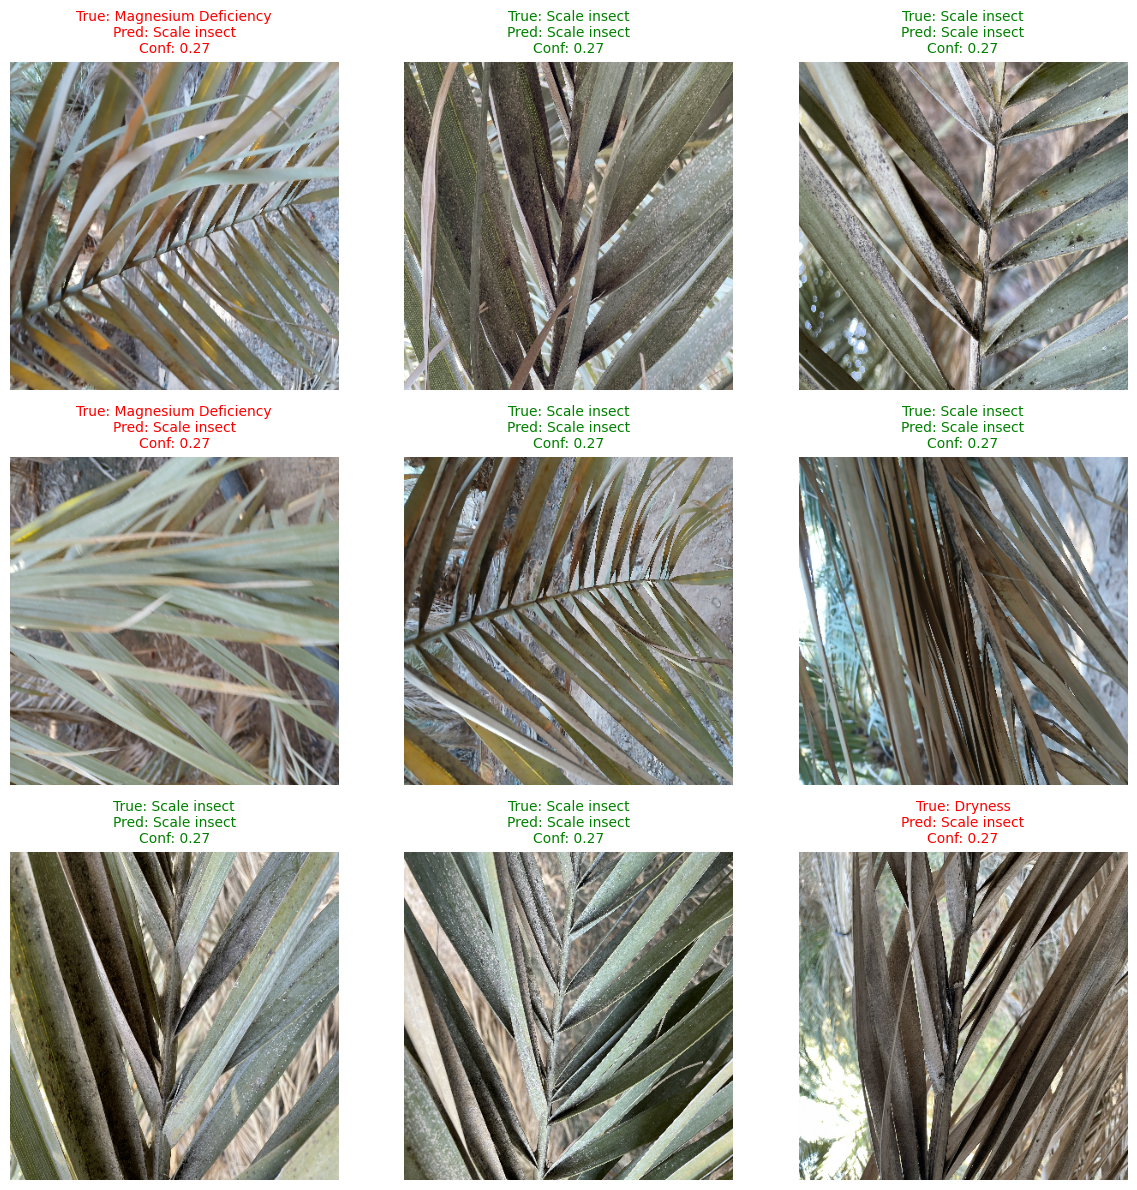

 Predictions visualized


In [16]:
def visualize_predictions(num_images=9):
    """Visualize random test predictions."""
    indices = np.random.choice(len(X_test), num_images, replace=False)

    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    axes = axes.ravel()

    for i, idx in enumerate(indices):
        img = X_test[idx]
        true_label = classes[y_test[idx]]
        pred_label = classes[y_pred[idx]]
        confidence = y_pred_probs[idx, y_pred[idx]]

        axes[i].imshow(img)
        color = 'green' if y_test[idx] == y_pred[idx] else 'red'
        axes[i].set_title(f"True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}",
                         color=color, fontsize=10)
        axes[i].axis('off')

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/predictions.png', dpi=150, bbox_inches='tight')
    plt.show()

visualize_predictions()
print(" Predictions visualized")

In [17]:
# Save as SavedModel format (recommended for TFLite/TFServing/etc.)
export_dir = "palm_disease_model"
model.export(export_dir) # Changed model.save to model.export
print(f" Model saved to: {export_dir}")

# Also save as H5 for compatibility
h5_path = "palm_disease_model.h5"
model.save(h5_path)
print(f" Model saved to: {h5_path}")

print("\n" + "="*60)
print("TRAINING COMPLETE!")
print("="*60)


Saved artifact at 'palm_disease_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 384, 384, 3), dtype=tf.float32, name='keras_tensor_270')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  139033265706512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139033265706704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139033265709392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139033265705744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139033265710352: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  139033265710160: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  139033265709776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139033265712656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139033265713232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139033265712080: TensorSpec(shape=(), dtype=tf.resource, nam

 Model saved to: palm_disease_model
 Model saved to: palm_disease_model.h5

TRAINING COMPLETE!
